In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e8/sample_submission.csv
/kaggle/input/playground-series-s4e8/train.csv
/kaggle/input/playground-series-s4e8/test.csv


In [2]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e8/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
import lightgbm as lgb
import optuna
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
# warnings.filterwarnings('ignore')

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

In [5]:
df_train.isnull().sum()

id                            0
class                         0
cap-diameter                  4
cap-shape                    40
cap-surface              671023
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            1258435
gill-color                   57
stem-height                   0
stem-width                    0
stem-root               2757023
stem-surface            1980861
stem-color                   38
veil-type               2957493
veil-color              2740947
has-ring                     24
ring-type                128880
spore-print-color       2849682
habitat                      45
season                        0
dtype: int64

In [6]:
df_train.duplicated().sum()

0

In [7]:
df_train.shape

(3116945, 22)

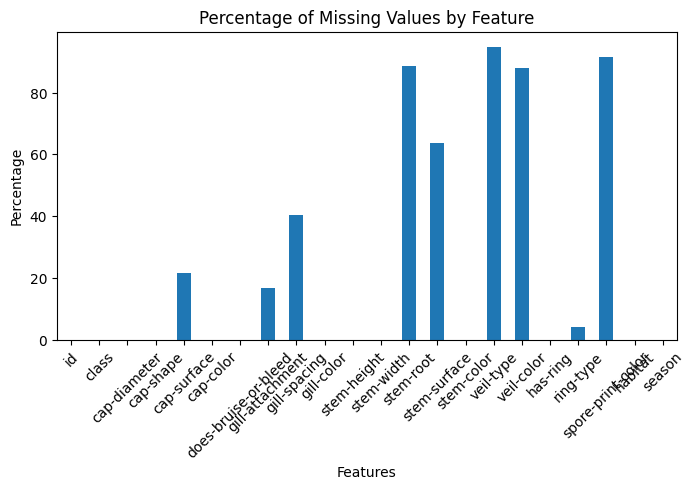

In [8]:
import matplotlib.pyplot as plt

missing_values = df_train.isnull().mean() * 100

# Plot
missing_values.plot(kind='bar', figsize=(8, 4))

plt.title('Percentage of Missing Values by Feature')
plt.ylabel('Percentage')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.show()

In [9]:
import seaborn as sns

# plt.figure(figsize=(18,12))
# plt.title("Visualizing Missing Values")
# sns.heatmap(df_train.isnull(), cbar=False, cmap=sns.color_palette("Spectral_r", n_colors=13), yticklabels=False);

In [10]:
categorical_cols = [col for col in df_train.columns if df_train[col].dtype == 'category' and col != 'class']
continuous_cols = [col for col in df_train.columns if df_train[col].dtypes == 'float16']
FEATURES = [col for col in df_train.columns if col not in ['id', 'class']]
TARGET = 'class'

In [11]:
# sns.set_style('darkgrid')

def categorical_distributions_plot(df, cols, rows_num=6, cols_num=3):
    fig = plt.figure(figsize=(16, 32))
    
    for idx, col in enumerate(cols):
        ax = fig.add_subplot(rows_num, cols_num, idx + 1)
        temp = df[col].value_counts().nlargest(10).reset_index()
        temp.columns = [col, 'count']
        sns.barplot(y=col, x='count', data=temp, palette='Set2', ax=ax, order=temp[col])
        
        ax.set_xlabel('Count', fontsize=12)
        ax.set_ylabel(col, fontsize=12)
        ax.set_title(f'Distribution of {col}', fontsize=14)
        ax.xaxis.set_tick_params(rotation=45)
        ax.yaxis.set_tick_params(rotation=0)
        
        for container in ax.containers:
            ax.bar_label(container, fontsize=10)
    
    fig.tight_layout()
    plt.show()


In [12]:
categorical_distributions_plot(df_train, categorical_cols)

<Figure size 1600x3200 with 0 Axes>

In [13]:
def categorical_vs_target_plot(df, cols, target, rows_num=6, cols_num=3):
    fig = plt.figure(figsize=(16, 14))
    
    for idx, col in enumerate(cols):
        ax = fig.add_subplot(rows_num, cols_num, idx + 1)
        target_distribution = df.groupby(col)[target].value_counts(normalize=True).unstack().fillna(0)
        top_categories = df[col].value_counts().nlargest(10).index
        target_distribution = target_distribution.loc[top_categories]
        target_distribution = target_distribution.sort_values(by=target_distribution.columns.tolist(), ascending=False)
        target_distribution.plot(kind='bar', stacked=True, colormap='Set2', edgecolor='black', alpha=0.7, ax=ax)
        
        ax.set_xlabel(col, fontsize=12)
        ax.set_ylabel('Proportion', fontsize=12)
        ax.set_title(f'{col} and {target}', fontsize=14)
        ax.xaxis.set_tick_params(rotation=45)
        ax.yaxis.set_tick_params(rotation=0)
        ax.legend(title=target, fontsize=10)
    
    fig.tight_layout()
    plt.show()

In [14]:
categorical_vs_target_plot(df_train, categorical_cols, 'class')

<Figure size 1600x1400 with 0 Axes>

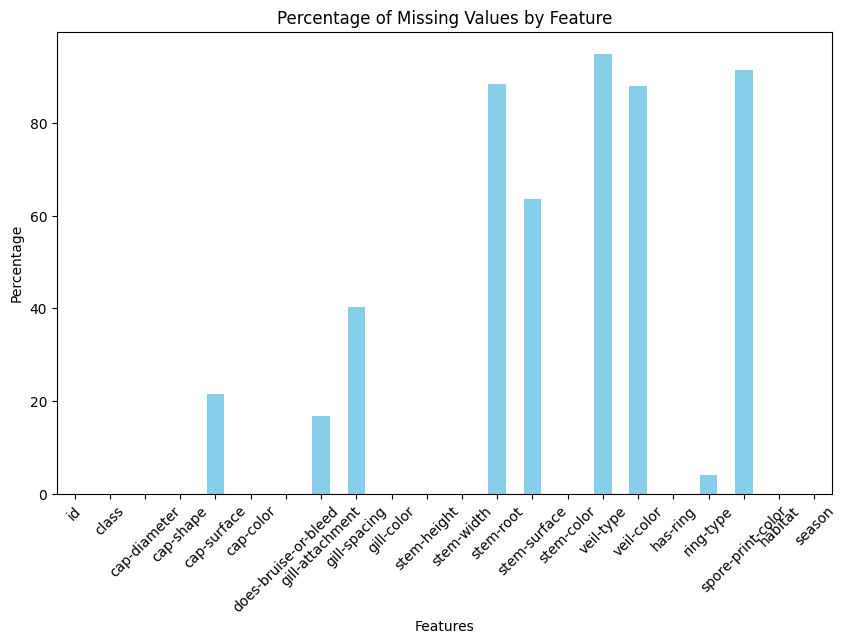

In [15]:
missing_values = df_train.isnull().mean() * 100

# Plot
missing_values.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Percentage of Missing Values by Feature')
plt.ylabel('Percentage')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.show()

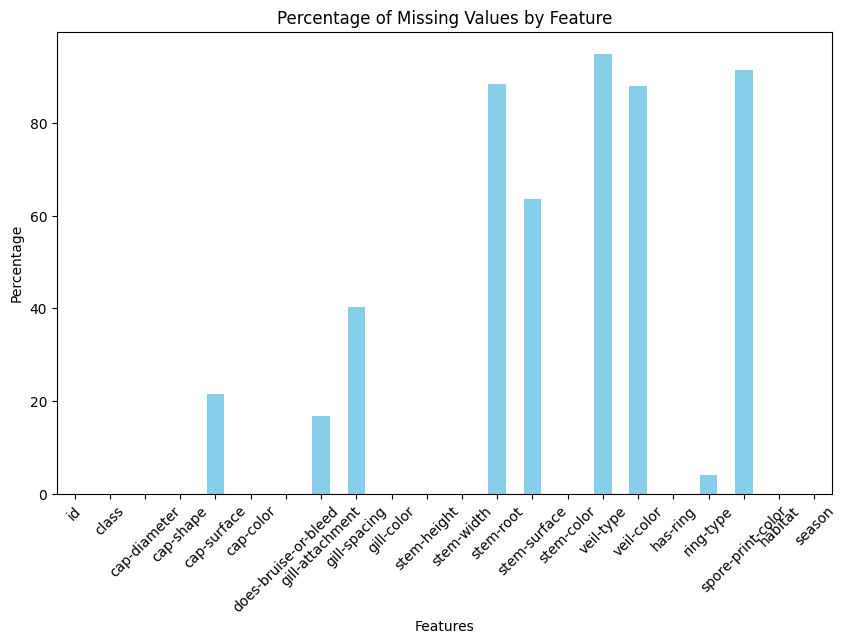

In [16]:
missing_values = df_train.isnull().mean() * 100

# Plot
missing_values.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Percentage of Missing Values by Feature')
plt.ylabel('Percentage')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.show()

In [17]:
import seaborn as sns
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
import optuna
from optuna.samplers import TPESampler
import warnings
import shap
warnings.filterwarnings("ignore")
from sklearn.metrics import matthews_corrcoef

In [18]:
train = df_train
test = df_test

In [19]:
# train = pd.concat([train, train_original], ignore_index=True)
cols = train.columns.to_list()
cols.remove("class")
train = train.drop_duplicates(subset=cols, keep='first')

def cleaning(data):
    
    threshold = 100
    
    cat_feats = ["cap-shape","cap-surface","cap-color","does-bruise-or-bleed","gill-attachment",
                "gill-spacing","gill-color","stem-root","stem-surface","stem-color","veil-type",
                "veil-color","has-ring","ring-type","spore-print-color","spore-print-color",
                "habitat","season"]
    
    for feat in cat_feats:
        data[feat] = data[feat].fillna('missing')
        data.loc[data[feat].value_counts(dropna=False)[data[feat]].values < threshold, feat] = "noise"
        data[feat] = data[feat].astype('category')
    
    return data

train  = cleaning(train)
test = cleaning(test)

X_train = train.drop(["class", "id"], axis=1)
X_test = test.drop("id", axis=1)
y_train = (train["class"] == 'p').astype('int')

In [20]:
cv = KFold(5, shuffle=True, random_state=0)
cv_splits = cv.split(X_train, y_train)
scores = list()
model = LGBMClassifier(objective='binary', random_state=0, verbosity = -1,)
for i, (train_idx, val_idx) in enumerate(cv_splits):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_val_fold)
    MCC = matthews_corrcoef(y_val_fold, y_pred)
    print(f"Fold {i} MCC score: {MCC:.5f}")
    scores.append(MCC)
    
print(f'Mean MCC score: {np.mean(scores):.5f}')

Fold 0 MCC score: 0.98097
Fold 1 MCC score: 0.98137
Fold 2 MCC score: 0.98108
Fold 3 MCC score: 0.98069
Fold 4 MCC score: 0.98114
Mean MCC score: 0.98105


In [21]:
def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 400, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 2500),
        'subsample_for_bin': trial.suggest_int('subsample_for_bin', 20000, 300000),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 100.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 100.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'subsample': trial.suggest_float('subsample', 0.25, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 15)
    }
    
    model = LGBMClassifier(**params, random_state=0, objective='binary', verbosity = -1)
    X, X_val, y, y_val = train_test_split(X_train, y_train, random_state=0, stratify=y_train, test_size=0.2, shuffle=True)
    model.fit(X, y)
    y_pred = model.predict(X_val)
    return matthews_corrcoef(y_val, y_pred)
    

sqlite_db = "sqlite:///lgbm.db"
study_name = "lgbm"
optimize = False
if optimize:
    study = optuna.create_study(storage=sqlite_db, study_name=study_name, 
                                sampler=TPESampler(n_startup_trials=50, multivariate=True, seed=0),
                                direction="maximize", load_if_exists=True)

    study.optimize(objective, n_trials=150)
    print(f"best optimized MCC: {study.best_value:0.5f}") # 0.98521
    print(f"best hyperparameters: {study.best_params}") 
    lgbm_params = study.best_params
else:
    lgbm_params = {
        'num_leaves': 459, 
        'learning_rate': 0.029054776460531954, 
        'n_estimators': 1188, 
        'subsample_for_bin': 36805,
        'min_child_samples': 180, 
        'reg_alpha': 2.701133349161215, 
        'reg_lambda': 2.3413285519209658e-08, 
        'colsample_bytree': 0.6248142892362624, 
        'subsample': 0.6193856517174553, 
        'max_depth': 11
    }

In [22]:
model = LGBMClassifier(**lgbm_params, random_state=0, objective='binary', verbosity = -1)
X, X_val, y, y_val = train_test_split(X_train, y_train, random_state=0, stratify=y_train, test_size=0.2)
model.fit(X, y)
y_pred = model.predict(X_val)
preds = model.predict(X_test)
print(f"Final MCC score: {matthews_corrcoef(y_val, y_pred):0.5f}")

Final MCC score: 0.98481


In [23]:
ids = df_test['id']

In [24]:
# submission = pd.read_csv("/kaggle/input/playground-series-s4e8/sample_submission.csv")
# submission["class"] = preds
# submission["class"] = np.where(submission["class"] == 1, 'p', 'e')
# submission.to_csv('submission.csv',index=False)
# submission.head(10)

In [25]:
output2 = pd.DataFrame({'id': ids,
                       'class': preds.squeeze()})
output2["class"] = np.where(output2["class"] == 1, 'p', 'e')
output2.to_csv('submission.csv', index= False)